# init

In [0]:
#Set up and import all libraries and utilities needed to execute the Pommerman project
import os
import sys
import numpy as np

#Download Pommerman enviorment from the repository
!git clone https://github.com/esbenlkruse/Pommerman

os.chdir('Pommerman')
os.chdir('playground')

!python setup.py install

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

!pip install emoji

# install gym
! pip install git+https://github.com/openai/gym

Cloning into 'Pommerman'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 109 (delta 10), reused 103 (delta 9), pack-reused 0
Receiving objects: 100% (109/109), 1.12 MiB | 4.31 MiB/s, done.
Resolving deltas: 100% (10/10), done.
running install
running bdist_egg
running egg_info
creating pommerman.egg-info
writing pommerman.egg-info/PKG-INFO
writing dependency_links to pommerman.egg-info/dependency_links.txt
writing entry points to pommerman.egg-info/entry_points.txt
writing requirements to pommerman.egg-info/requires.txt
writing top-level names to pommerman.egg-info/top_level.txt
writing manifest file 'pommerman.egg-info/SOURCES.txt'
reading manifest file 'pommerman.egg-info/SOURCES.txt'
writing manifest file 'pommerman.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/l

In [0]:
try: 
  import gym
  !pom_battle
except ImportError:
    print("Please restart and run all.")

Import error GL! You will not be able to render --> Library "GLU" not found.
/usr/local/lib/python3.6/dist-packages/gym-0.10.9-py3.6.egg/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
Starting the Game.
Final Result:  {'result': <Result.Tie: 2>}
Game Time:  2.694065809249878


# CODE

This notebook demonstrates how to train Pommerman agents. Please let us know at support@pommerman.com if you run into any issues.

In [0]:
from pommerman.agents import SimpleAgent, RandomAgent, PlayerAgent, BaseAgent
from pommerman.configs import ffa_v0_fast_env
from pommerman.envs.v0 import Pomme
from pommerman.characters import Bomber
from pommerman import utility

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym

# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])

#CUDA
use_cuda = torch.cuda.is_available()
#use_cuda = False

device = torch.device("cuda:0" if use_cuda else "cpu")
print("Using device:", device)

Import error GL! You will not be able to render --> Library "GLU" not found.
Using device: cuda:0


## Load init game state

In [0]:
% rm "initGameState.json"

rm: cannot remove 'initGameState.json': No such file or directory


In [0]:
from google.colab import files
import io
uploaded = files.upload()

Saving initGameState.json to initGameState.json


In [0]:
class QNetwork(nn.Module):
    """Q-network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(QNetwork, self).__init__()
        # network
        self.out = nn.Linear(n_inputs, n_outputs, bias=False)
        torch.nn.init.uniform_(self.out.weight, 0, 0.01)
        # training
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        
    def forward(self, x):
        #x = self.dense(x)
        #x = self.activation(x) #x = nn.ReLU(x)
        x = self.out(x)
        return x
    
    def loss(self, q_outputs, q_targets):
        return torch.sum(torch.pow(q_targets - q_outputs, 2))
def one_hot(i, l):
    """One-hot encoder for the states"""
    a = np.zeros((len(i), l))
    a[range(len(i)), i] = 1
    return a
  
def check_lists(b,p,o1,o2,o3):
    killer = 0
    suicide = False

    if(b == p):
        suicide = True
    if(b == o1):
        killer += 1
    if(b == o2):
        killer += 1
    if(b == o3):
        killer += 1

    return killer, suicide
  

def featurize(obs):
    position = obs["position"]
    
    scopeSize = 5
    padSize = scopeSize - 1
    
    # Scope agent view for board
    outOfBoundsType = 14
    board = obs["board"]
    bPaddingSize = 11 + (padSize * 2)
    paddedBoard = np.full((bPaddingSize, bPaddingSize), outOfBoundsType, dtype=int)
    paddedBoard[padSize : board.shape[0] + padSize, padSize : board.shape[1] + padSize] = board
    (r, c) = position
    (rp, cp) = (r + padSize, c + padSize)

    scopedBoard = paddedBoard[r : rp + padSize + 1, c : cp + padSize + 1].reshape(-1)
    #print(paddedBoard[r : rp + padSize + 1, c : cp + padSize + 1])
    
    # Scope agent view for bomb blast strength
    bomb_blast_strength = obs["bomb_blast_strength"]
    paddedBombBlastStrength = np.zeros((bPaddingSize, bPaddingSize), dtype=int)
    paddedBombBlastStrength[padSize : bomb_blast_strength.shape[0] + padSize, padSize : bomb_blast_strength.shape[1] + padSize] = bomb_blast_strength

    scopedBombBlastStrength = paddedBombBlastStrength[r : rp + padSize + 1, c : cp + padSize + 1].reshape(-1)
    #print(paddedBombBlastStrength[r : rp + padSize + 1, c : cp + padSize + 1])
    
    
    # Scope agent view for bomb life
    bomb_life = obs["bomb_life"]
    paddedBombLife = np.zeros((bPaddingSize, bPaddingSize), dtype=int)
    paddedBombLife[padSize : bomb_life.shape[0] + padSize, padSize : bomb_life.shape[1] + padSize] = bomb_life

    scopedBombLife = paddedBombLife[r : rp + padSize + 1, c : cp + padSize + 1].reshape(-1)
    #print(paddedBombLife[r : rp + padSize + 1, c : cp + padSize + 1])
    
    
    ammo = [obs["ammo"]]
    blast_strength = [obs["blast_strength"]]
    can_kick =[obs["can_kick"]]
    actionlist = obs['actionlist']
    
    teammate = obs["teammate"]
    if teammate is not None:
        teammate = teammate.value
    else:
        teammate = -1
    teammate = [teammate]

    enemies = obs["enemies"]
    enemies = [e.value for e in enemies]
    if len(enemies) < 3:
        enemies = enemies + [-1]*(3 - len(enemies))
    enemies = enemies

    
    output = []
    
    elements = [scopedBoard, scopedBombBlastStrength, scopedBombLife, position, ammo, blast_strength, can_kick, actionlist]
    sizes    = [15, 12, 11, 11, 11, 12, 2, 7]
    #sizes    = [15, 32, 10, 11, 32, 12, 2, 7]
    
    for (i, n) in zip(elements,sizes):
        
        if isinstance(i, tuple) or isinstance(i, list):
          i = [int(i[index]) for index in range(len(i))]
        else:
          i = i.astype(int)
        output = np.concatenate((output, one_hot(i,n).reshape(-1)), axis=0) #.astype(np.float32)
    out = np.array([output])
    return out

In [0]:
class RewardsShaper:
    def __init__(self):
        self.bomb_list = {'own_bombs':{},'other_bombs':{}}
        

    def run(self, s, a, s1, done, info):
        reward = 0
        lookup = ['Stop', 'Up', 'Down', 'Left', 'Right', 'Bomb']
        
        a = a[3]
        
        p  = s[3]['position']
        p1 = s1[3]['position']
        o1 = s[0]['position']
        o2 = s[1]['position']
        o3 = s[2]['position']
        
        # Update bomb_list
        if(a == 5 and s1[3]['bomb_life'][ p[0] ][ p[1] ] == 9):
          
          self.bomb_list['own_bombs'][str(p[0])+","+str(p[1])] = {
              'position': [ p[0], p[1] ],
              'strength': s[3]['blast_strength']
          }

        suicide = False;
        killer = 0
        chopTree = 0
        
        # Check if own bomb goes off
        for key, value in self.bomb_list['own_bombs'].items():
          b = (value['position'][0], value['position'][1])
          if(s[3]['bomb_life'][ b[0] ][ b[1] ] == 1): # Own bombs goes off at bomb_life = 1
            
            fire_list = []
            blast_strength = self.bomb_list['own_bombs'][key]['strength']
            
            fire_list.append(b)
            for i in range(1,blast_strength):  
              if (b[0] - i >= 0):
                if (s1[3]['board'][ b[0]-i ][ b[1] ] == 4):
                    fire_list.append( (b[0]-i, b[1]) )
              
              if ( b[0] + i < 11):
                if (s1[3]['board'][ b[0]+i ][ b[1] ] == 4):
                    fire_list.append( (b[0]+i, b[1]) )
              
              if (b[1] - i >= 0):
                if (s1[3]['board'][ b[0] ][ b[1]-i ] == 4):
                    fire_list.append( (b[0], b[1]-i) )
              
              if (b[1] + i < 11):
                if (s1[3]['board'][ b[0] ][ b[1]+i ] == 4):
                    fire_list.append( (b[0], b[1]+i) )
            
                                 
            del self.bomb_list['own_bombs'][key]
            
            if(p1 in fire_list):
                suicide = True
            
            if(o1 in fire_list):
              killer += 1
              
            if(o2 in fire_list):
              killer += 1
              
            if(o3 in fire_list):
              killer += 1
            
            
            for pos in fire_list:
              if(s[3]['board'][pos] == 2):
                chopTree += 1
                
            break
               
        #print("killer, suicide, chopTree: ", killer, int(suicide), chopTree)
        
        #if(killer > 0):
        #  print("K",end="")

        # Reward: Lay bombs and have ammo
        if(a == 5 and s[3]["ammo"]>0):
            reward += 0.1
            
        # Penalty: Lay bombs and have no ammo
        elif(a == 5 and s[3]["ammo"]==0):
            reward -= 0.1

        # Penalty: Go into fire! or stone, wood or off the board
        y, x = s[3]["position"]

        if(a==3): # action is go left
          if(p[1]-1>=0): # is on the board
            next_pos = s[3]['board'][ p[0] ][ p[1]-1 ]
            if(next_pos == 4): # fire
              reward -= 1
            elif(next_pos == 1 or next_pos == 2): # stone or wood
              reward -= 0.1
          else: # on not the board
            reward -= 0.1

        elif(a==4): # action is go right
          if(p[1]+1<11): # is on the board
            next_pos = s[3]['board'][ p[0] ][ p[1]+1 ]
            if(next_pos == 4): # and fire to the right
              reward -= 1
            elif(next_pos == 1 or next_pos == 2): # stone or wood
              reward -= 0.1
          else: # not the board
            reward -= 0.1
            
        elif(a==2): # action is go down
          if(p[0]-1>=0): # is on the board
            next_pos = s[3]['board'][ p[0]-1 ][ p[1] ]
            if(next_pos == 4): # and fire under
              reward -= 1
            elif(next_pos == 1 or next_pos == 2): # stone or wood
              reward -= 0.1
          else: # not the board
            reward -= 0.1

        elif(a==1): # action is go up
          if(p[0]+1<11): # is on the board
            next_pos = s[3]['board'][ p[0]+1 ][ p[1] ]
            if(next_pos == 4): # and fire over
              reward -= 1
            elif(next_pos == 1 or next_pos == 2): # stone or wood
              reward -= 0.1
          else: # not the board
            reward -= 0.1

        # Penalty: Go into the line of fire!
        #y, x = s["position"]

        # Penalty: Don't stand still for more than 10 turns
        index = 0
        counter = 0
        for i in range(len(ep_actions)):
          counter+=1
          if(ep_actions[-counter])!=0:
            counter-=1
            break
        
        if(counter>9):
          reward += (9-counter)
          
        # reward: picking up powerups!
        powerup = 0
        if (s1[3]['blast_strength'] > s[3]['blast_strength']):## incr range
          powerup += 1
          
        if (s[3]['board'][ p1 ] == 6): ## extra bomb
          powerup += 1
        
        if (s[3]['can_kick'] == False and s1[3]['can_kick'] == True):  ## can kick
          powerup += 1
        
        
        reward += 4*powerup
        reward += -3*suicide
        reward += 10*killer
        reward += 2*chopTree
        
        #print("reward was:",reward)
        return reward, suicide

In [0]:
from google.colab import files
import io
uploaded = files.upload()


Saving QNmaster10000Filip_discount09.pth.tar to QNmaster10000Filip_discount09.pth.tar


In [0]:
# Add own agent

class OwnAgent(BaseAgent):
    """The Own Agent that returns random actions given an action_space."""
    def __init__(self, character=Bomber):
        self._character = character
        #self.n_inputs = 4228   #4158
        #self.n_inputs = 3114
        self.n_inputs = 3195
        self.n_hidden = 846
        self.n_inputs_size = 14
        self.n_outputs = 6
        self.learning_rate = 0.0005 #0.001
        self.gamma = 0.99 # discount rate
        self.actionlist = [6,6,6,6,6,6,6,6,6,6]
        
        self.qnet = QNetwork(self.n_inputs, self.n_hidden, self.n_outputs, self.learning_rate)
        if use_cuda:
          self.qnet.cuda()
        buffer = io.BytesIO(uploaded["QNmaster10000Filip_discount09.pth.tar"])
        self.qnet.load_state_dict(torch.load(buffer))
        self.master = SimpleAgent(config["agent"](agent_id, config["game_type"]))
    
    
    def act(self, obs, action_space):
        obs['actionlist'] = self.actionlist
        self.Q = self.qnet(torch.from_numpy(featurize(obs)).float().to(device))
        
        #a = self.Q.argmax().item()
        a = self.master.act(obs, env.action_space)
        self.actionlist.insert(0,a)
        del self.actionlist[10]
        return a

In [0]:
# Agent setup
agents = {}

agent_id=0; agents[agent_id] = SimpleAgent(config["agent"](agent_id, config["game_type"]))
agent_id=1; agents[agent_id] = SimpleAgent(config["agent"](agent_id, config["game_type"]))  
agent_id=2; agents[agent_id] = SimpleAgent(config["agent"](agent_id, config["game_type"])) 
agent_id=3; agents[agent_id] = OwnAgent(config["agent"](agent_id, config["game_type"]))

env.set_agents(list(agents.values()))
env.set_init_game_state(None)

# Load file

In [0]:
#buffer = io.BytesIO(uploaded["simple_master2.pth.tar"])
##print(buffer.getvalue())
#agents[3].qnet.load_state_dict(torch.load(buffer))

# START VALIDATION

In [0]:
from IPython.display import clear_output
import time
import copy

num_episodes = 1000
#epsilon = 1.0
epsilon = 0
episode_limit = 1000
val_freq = 100

shapedreward = RewardsShaper()
rewards, lengths, losses, epsilons, wins, actionlog = [], [], [], [], [0] * num_episodes, []
print('start training')
for i in range(num_episodes):
    # init new episode
    env.set_init_game_state('initGameState.json')
    s, ep_reward, ep_loss,suicide, ep_actions = env.reset(), 0, 0, 0, []
    q_values = []
    r = 0

    for j in range(episode_limit):
        actions = env.act(s)
        s1, r, done, info = env.step(actions)
        if(13 in s[3]['alive']):
          shaped, suicide = shapedreward.run(s, actions, s1, done, info)
        s = copy.deepcopy(s1)
        if done: break
        ep_actions.append(actions[3])
# episode is finished 
    if(suicide>0):
      print("s",end="")
      wins.append(0)
    elif("winners" in info):
      if(3 in info["winners"]):
        ep_reward += 1
        wins.append(1)
        print("w",end="")
      else:
        ep_reward -= 1
        wins.append(0)
        print(".",end="")
    else:
        ep_reward -= 1
        wins.append(0)
        print(".",end="")
    actionlog.append(ep_actions)
    if (i+1) % val_freq == 0:print('{:5d} and wins: {:5.2f}%'.format(i+1, np.mean(wins[-val_freq:])*100))
print("END")
    

start training
w.w..ss.wswwss.wsw..ws.sws.wssss.ssss.s..ss..ssss.w..s.swssw.sw..ss.s..ss..w.wwsw.w..s..ssw.sws.ss..s.s.s..s.sw.s.wwsw.w.s.ssww...ssws.s...sswss.sw.swsss.swssssws.ss.s.sws..sss.wwss.swsss.wsw.s.s..wss.sssssw.wsws....w.ss.s.s...w.ww..sswswsssw.s.w.wsw..ss.swsss.w.s.w.....ss.wss.ss.w..sss..w..s.....w.sssw...s.ws.sswsw.ws.ssswsws..sss.wwss.swwss..swwss...ssww...sss......s...wsws.ssssswsws.s.ss.sw.w..w..s....s..ssssw..s.w.ssss.ss.sw...ssssw.ss.wws.ss.swwssws.ww.ws.swwss.s.s..s..ssws.ss.sswsssssss.s.sss...s...wws.sss.sw...s......sswsw..w..sww.ws..sww.ww.sww.s.ws..ss..swsssw.ssss.sw.w.sww.....s......swsssw..ws.s...s...s.sss.w.wwssss...s.s.s.s..ww.s..sw.ss.ssssss.ssws.s.swwsswssswswwwswwssws.swss.s..w.sw.ss.ww.sssssw.s...w...wwss.ww.w.sssw..wwssss.ws..sws.ww..w..w..sww..s.sw.s.ww.wsss...s.s.ss..w....s......sssss...ssss.sws....w.sss..sw.wssw.s.wwws..s.w...ssw.w.ssssss.ww.s.wwssw..ss.sss...sw..sw.wsw..sw..s.wssss....w...ssw.ss....sss.wsws..wss.ss.s.sws.sssssswsss.s....sw.w.sss...

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [0]:
text ="w.w..ss.wswwss.wsw..ws.sws.wssss.ssss.s..ss..ssss.w..s.swssw.sw..ss.s..ss..w.wwsw.w..s..ssw.sws.ss..s.s.s..s.sw.s.wwsw.w.s.ssww...ssws.s...sswss.sw.swsss.swssssws.ss.s.sws..sss.wwss.swsss.wsw.s.s..wss.sssssw.wsws....w.ss.s.s...w.ww..sswswsssw.s.w.wsw..ss.swsss.w.s.w.....ss.wss.ss.w..sss..w..s.....w.sssw...s.ws.sswsw.ws.ssswsws..sss.wwss.swwss..swwss...ssww...sss......s...wsws.ssssswsws.s.ss.sw.w..w..s....s..ssssw..s.w.ssss.ss.sw...ssssw.ss.wws.ss.swwssws.ww.ws.swwss.s.s..s..ssws.ss.sswsssssss.s.sss...s...wws.sss.sw...s......sswsw..w..sww.ws..sww.ww.sww.s.ws..ss..swsssw.ssss.sw.w.sww.....s......swsssw..ws.s...s...s.sss.w.wwssss...s.s.s.s..ww.s..sw.ss.ssssss.ssws.s.swwsswssswswwwswwssws.swss.s..w.sw.ss.ww.sssssw.s...w...wwss.ww.w.sssw..wwssss.ws..sws.ww..w..w..sww..s.sw.s.ww.wsss...s.s.ss..w....s......sssss...ssss.sws....w.sss..sw.wssw.s.wwws..s.w...ssw.w.ssssss.ww.s.wwssw..ss.sss...sw..sw.wsw..sw..s.wssss....w...ssw.ss....sss.wsws..wss.ss.s.sws.sssssswsss.s....sw.w.sss....sw.w.ww.ss.sss"
print("percent killed: ", (text.count(".")/1000)*100, "%", "percent suicide: ", (text.count("s")/1000)*100, "%", "percent win!: ", (text.count("w")/1000)*100, "%")

percent killed:  38.3 % percent suicide:  41.3 % percent win!:  20.4 %


In [0]:
## if there is an error resize the wins and num_episodes to still be able to pring
if(len(rewards)!=num_episodes):
  new_lenght = len(rewards)
  num_episodes = new_lenght
  wins = wins[:new_lenght]

# Plot results

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


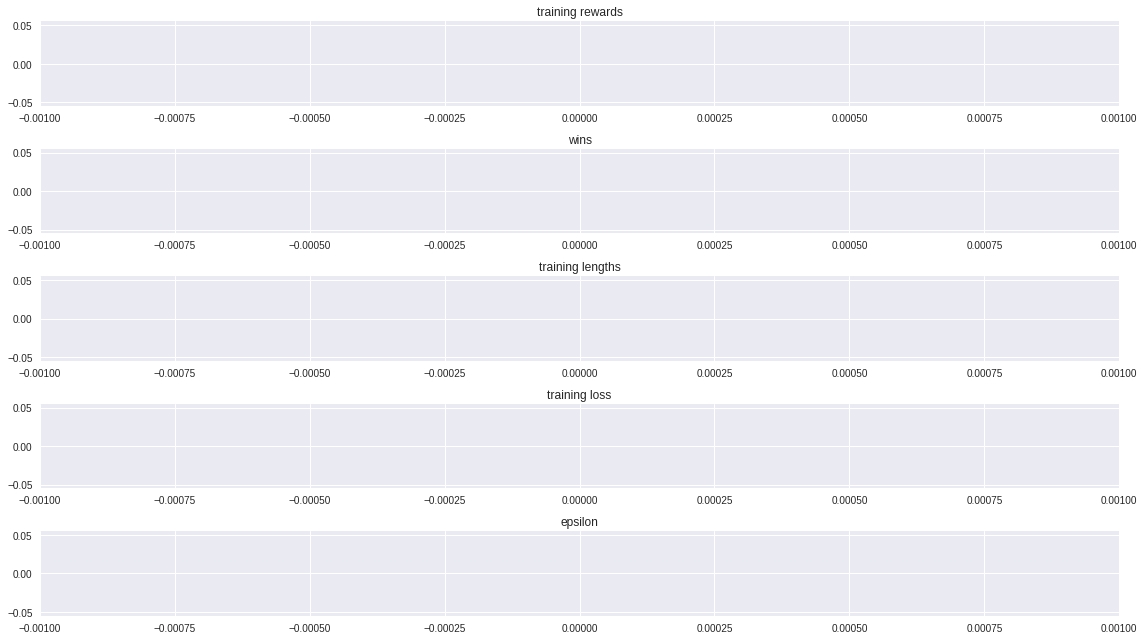

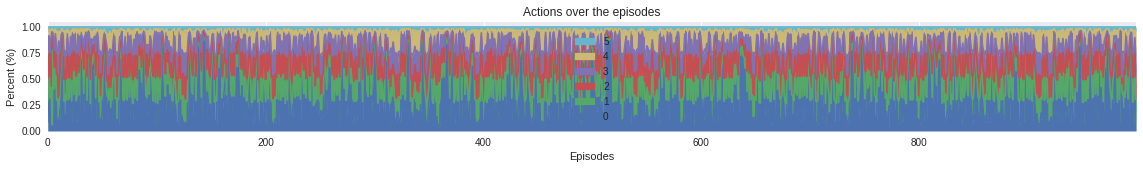

In [0]:
# plot results

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16, 9))

plt.subplot(511)
plt.title('training rewards')
plt.plot(range(1, num_episodes+1), rewards)
plt.plot(range(1, num_episodes+1), moving_average(rewards))
plt.xlim([0, num_episodes])

plt.subplot(512)
plt.title('wins')
plt.plot(range(1, num_episodes+1), wins)
plt.plot(range(1, num_episodes+1), moving_average(wins))
plt.xlim([0, num_episodes])

plt.subplot(513)
plt.title('training lengths')
plt.plot(range(1, num_episodes+1), lengths)
plt.plot(range(1, num_episodes+1), moving_average(lengths))
plt.xlim([0, num_episodes])

plt.subplot(514)
plt.title('training loss')
plt.plot(range(1, num_episodes+1), losses)
plt.plot(range(1, num_episodes+1), moving_average(losses))
plt.xlim([0, num_episodes])

plt.subplot(515)
plt.title('epsilon')
plt.plot(range(1, num_episodes+1), epsilons)
plt.xlim([0, num_episodes])

plt.tight_layout(); plt.show()

import pandas as pd
from collections import Counter

size = len(actionlog)
y = np.zeros((size,6))

for i in range(size):
  n = Counter(actionlog[i])
  for j in range(6):
    y[i][j] = n[j]
    
x = np.arange(size)
df = pd.DataFrame(y, index=x)

df = df.divide(df.sum(axis=1), axis=0)
ax = df.plot(kind='area', stacked=True, title='Actions over the episodes', figsize=(19.5, 2),legend = 'reverse')

ax.set_xlabel('Episodes'); ax.set_ylabel('Percent (%)')
ax.margins(0, 0) # Set margins to avoid "whitespace"

plt.show()

# Save file

In [0]:
#from google.colab import files
#torch.save(agents[3].qnet.state_dict(), "simple_master2.pth.tar")
#files.download( "simple_master2.pth.tar" ) 

In [0]:
from google.colab import files
torch.save(agents[3].qnet.state_dict(), "simple_master2.pth.tar")
files.download( "simple_master2.pth.tar" ) 

# Animation

In [0]:
lookup = ['Stop', 'Up', 'Down', 'Left', 'Right', 'Bomb']

print("Last Episode\n")

for i in range(len(actionlog[-1])):
  print("Action and q_values: \t {} \t {} \t {}".format(lookup[actionlog[-1][i]], ep_actions[i], np.round_(q_values[i].data.cpu().numpy()) ))

print("\nLenght of this episode was {}".format(len(actionlog[-1])))
  
print("\nReward and loss for this episode was {} and {}".format(rewards[-1],  round(losses[-1])))

Last Episode



IndexError: ignored

In [0]:
#print(np.round_(q_values.data.cpu().numpy()) )
q_values

[]

In [0]:
import emoji

def myRender(stage):
  for i in stage:
    for j in i:
      if(j==0): # free ground
        j = emoji.emojize(":white_question_mark:")
        #j = emoji.emojize(":white_large_square:")
      elif(j==1): # stone wall
        j = emoji.emojize(":mountain:")
      elif(j==2): # wooden wall
        j = emoji.emojize(":seedling:")
      elif(j==3): # bomb
        j = emoji.emojize(":bomb:")
      elif(j==4): # fire     
        j = emoji.emojize(":fire:")
      # 5 is fog
      
      #power ups
      elif(j==6): # extra bombs item     
        j = emoji.emojize(":pistol:")
      elif(j==7): # extra firepower     
        j = emoji.emojize(":collision:")
      elif(j==8): # kick     
        j = emoji.emojize(":running_shoe:")
      
        
      elif(j==10 or j==11 or j==12): #opponent
        j = emoji.emojize(":smiling_face_with_horns:")
      elif(j==13): #our agent
        j = emoji.emojize(":smiling_face_with_sunglasses:")

      print(j, end = "")
    print("")    

this_stage = s[3]['board']
myRender(this_stage)

❔⛰🌱🌱⛰⛰❔⛰🌱⛰❔
⛰❔❔❔🌱🌱🌱❔❔❔⛰
🌱❔❔❔🌱⛰⛰⛰⛰❔🌱
🌱😈❔❔⛰❔🌱⛰🌱😎⛰
⛰🌱🌱⛰❔❔⛰❔🌱🌱🌱
⛰🌱⛰❔❔❔❔❔⛰🌱❔
❔🌱⛰🌱⛰❔❔🌱⛰🌱🌱
⛰❔⛰⛰❔❔🌱❔⛰❔⛰
🌱❔⛰🌱🌱⛰⛰⛰❔❔❔
⛰❔❔😈🌱🌱🌱❔❔❔🔫
❔⛰🌱⛰🌱❔🌱⛰❔👟❔


In [0]:
from IPython.display import clear_output
import time

num_episodes = 1
#epsilon = 1.0
epsilon = 0
shapedreward = RewardsShaper()

rewards, lengths, losses, epsilons, wins, actionlog = [], [], [], [], [0] * num_episodes, []
print('start training')
for i in range(num_episodes):
    # init new episode
    s, ep_reward, ep_loss, ep_actions = env.reset(), 0, 0, []
    q_values = []
    r = 0

    for j in range(episode_limit):
        actions = env.act(s)
        s1, r, done, info = env.step(actions)
        
        clear_output()
        print("Round",j)
        myRender(s[3]['board'])  # Print the board at t
        
        print(actions[3],lookup[actions[3]]) #print action the agent takes
        if(j!=0):
          print(np.round_(agents[3].Q.data.cpu().numpy())) # print q values the action is based on
          print(np.round_(agents[3].Q1.data.cpu().numpy())) # print q values from the t+1
          print(loss.item())
        print()
        
        #print(s[3])

        
        if(13 in s[3]['alive']):
            #ep_actions.append(actions[3])
            shaped = shapedreward.run(s, actions, s1, done, info)
            ep_reward += shaped
            r[3] += shaped
            loss = agents[3].afterstep(s1[3], r[3], actions[3])

            # 6. bookkeeping
            ep_loss += loss.item()
            q_values.append(agents[3].Q)
        else:
          done = True
        
        #if(j>10):
        #  break
        time.sleep(1.5)  
        s = s1
        if done: break

    # episode is finished 
    if("winners" in info):
      if(3 in info["winners"]):
        ep_reward += 1
        wins[i] = 1
      else:
        ep_reward -= 1

    print(".",end="")
    print("episode reward was",ep_reward)
    

NameError: ignored

In [0]:
print(ep_reward)